# HSC
Markov process with fixed-size population with k-types such that the type 0 is the wild-type with growth rate of `B0`. 

A cells can get a mutation conferring a proliferative advantage upon cell division. We model this process with a Bernouilli trial with success probability of `u`, with units of 1 mutation/division. To compute `u` we can do `u =  MU0 / (2 * B0 * NCELLS)` for the symmetric division case.

For now, all k clones have the same proliferative advantage with k greater than 0.

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import socket
import seaborn as sns
import sys
from typing import Dict
from scipy import stats
from pathlib import Path
from ecdna_figures import dynamics, parse_version, distribution

PATH2BIN = Path("~").expanduser() / "hsc/target/release"
assert PATH2BIN.is_dir()
FIGSIZE = [7, 3]
PDF = True
EXTENSION = ".pdf" if PDF else ".png"
YEARS_FAST = 100 # TODO change to 50
RUNS = 32
NB_TIMEPOINTS = 10
assert YEARS_FAST > NB_TIMEPOINTS
SAVE = False

In [2]:
NCELLS = 200_000
# mean of the Bernouilli trial (prob of success) to get an asymmetric
# division upon cell division, units are [1 asymmetric division / division]
P_ASYMMETRIC = 0

## NEUTRAL RATES
# division rate for the wild-type in units of [division / (year * cell)]
# Welch, J.S. et al. (2012) ‘The Origin and Evolution of Mutations in Acute Myeloid Leukemia’,
# Cell, 150(2), pp. 264–278
B0 = 1  # TODO: double check this, should be between 2 and 20?
# Abascal, F. et al. (2021) ‘Somatic mutation landscapes at single-molecule resolution’,
# Nature, 593(7859), pp. 405–410. fig. 2b
# see also fig 1b of Mitchell, E. et al.
# (2022) ‘Clonal dynamics of haematopoiesis across the human lifespan’,
# Nature, 606(7913), pp. 343–350
NEUTRAL_RATE = 20  # [mut/(year * cell)]

## FIT CLONES
# avg fit mutations arising in 1 year, units are [mutations/year]
# from ABC's inference
MU0 = 2
# proliferative advantage conferred by fit mutations, all clones
# have the same proliferative advantage for now. Units are
# [mutation / division]
S = 0.11
# mean of the Bernouilli trial (prob of success) to get a fit variant upon
# cell division, units are [1 mutation/division]
if not P_ASYMMETRIC:
    u = MU0 / (2 * B0 * NCELLS)
else:
    u = MU0 / (B0 * NCELLS)
# should be 2.0 × 10−3 per HSC per year according to Mitchell, E. et al.
# (2022) ‘Clonal dynamics of haematopoiesis across the human lifespan’,
# Nature, 606(7913), pp. 343–350
# driver mutations enter the HSC compartment at 2.0 × 10−3 per HSC per year
print(f"average sucess rate of occurence of 1 fit mutation upon cell division u={u}")

average sucess rate of occurence of 1 fit mutation upon cell division u=5e-06


In [3]:
if socket.gethostname() == "5X9ZYD3":
    PATH2SIMS = Path(
        "/mnt/c/Users/terenz01/Documents/SwitchDrive/PhD/variantFractionTime_s0.15_sigma0.03_mu2.csv"
    )
    YEARS = YEARS_FAST
elif socket.gethostname() == "LAPTOP-CEKCHJ4C":
    PATH2SIMS = Path(
        "/mnt/c/Users/fra_t/Documents/PhD/variantFractionTime_s0.15_sigma0.03_mu2.csv"
    )
    # need + 1 to save the last timepoint
    YEARS = YEARS_FAST
else:
    PATH2SIMS = Path("~").expanduser() / Path(
        "variantFractionTime_s0.15_sigma0.03_mu2.csv"
    )
    YEARS = 100

x = np.linspace(1, YEARS, NB_TIMEPOINTS)
assert PATH2SIMS.is_file()

In [4]:
%%bash -s "$PATH2BIN" --out version
$1/hsc --version

In [5]:
VERSION = parse_version(version)
PATH2SAVE = Path(f"./{VERSION}")
print("Running hsc with version:", VERSION)
# check that path2save is set: we dont want to run 
# rm -rf (see bash cmd below)
assert PATH2SAVE

Running hsc with version: v0.8.1


In [6]:
%%bash -s "$PATH2BIN" "$PATH2SAVE" "$B0" "$MU0" "$NEUTRAL_RATE" "$S" "$P_ASYMMETRIC" "$RUNS" "$NCELLS" "$YEARS" "$NB_TIMEPOINTS"
rm -rf $2
$1/hsc -c $9 -y ${10} -r $8 --b0 $3 --mu0 $4 --neutral-rate $5 -s $6 --snapshots ${11} --p-asymmetric $7 $2

saving variant fraction at timepoints: [
    1.0,
    12.111111,
    23.222221,
    34.333332,
    45.444443,
    56.555553,
    67.666664,
    78.77777,
    89.888885,
    100.0,
]
2023-07-20 15:56:57.593399300 UTC starting simulation
2023-07-20 16:13:25.720261100 UTC End simulation


## The SFS

In [7]:
def load_sfs(path2dir: Path, neutral: bool, timepoint: int):
    """load all sfs for a specific timepoint.
    
    Remember that rust saves timepoints in decreasing order, hence
    the last timepoint is 1.
    """
    sfs = dict()
    path2sfs = PATH2SAVE / "sfs_neutral" if neutral else PATH2SAVE / "sfs"
    all_dirs = [x for x in path2sfs.iterdir() if x.is_dir()]
    assert (
        len(all_dirs) == NB_TIMEPOINTS
    ), f"Wrong nb of timepoints saved, should be {NB_TIMEPOINTS} found {len(all_dirs)}: {all_dirs}"
    # last_timepoint = min([int(x.stem) for x in all_dirs])
    last_timepoint_path = [x for x in all_dirs if int(x.stem) == timepoint][0]

    for i, file in enumerate(last_timepoint_path.iterdir(), 1):
        try:
            with open(file, "r") as f:
                sfs[file.stem] = {int(x): int(y) for x, y in json.load(f).items()}
        except json.JSONDecodeError as e:
            print(f"Error in opening {file} {e}")
            sys.exit(1)
    assert i == RUNS, f"wrong number of runs found: should be {RUNS} found {i}"
    assert (
        len(sfs) == RUNS
    ), f"wrong number of runs loaded: should be {RUNS} found {len(sfs)}"
    return sfs


def plot_sfs(sfs_: Dict[int, int], ax):
    ax.plot(
        list(sfs_.keys()),
        list(sfs_.values()),
        alpha=0.45,
        marker="v",
        linestyle="",
        label=k,
    )
    return ax

In [20]:
neutral_sfs = load_sfs(PATH2SAVE, neutral=True, timepoint=1)
# add zeros for values which are not present in all SFS
neutral_sfs_uniformised = distribution.uniformise(list(neutral_sfs.values()))
jcells = range(0, max(neutral_sfs_uniformised[0].keys()) + 1)
# take the Nj mutations for all simulations
avg_neutral_sfs = np.asarray(
    [list(n.values()) for n in neutral_sfs_uniformised], dtype=float
)
# compute the average, not pooling this time
avg_neutral_sfs = np.mean(avg_neutral_sfs, axis=0)

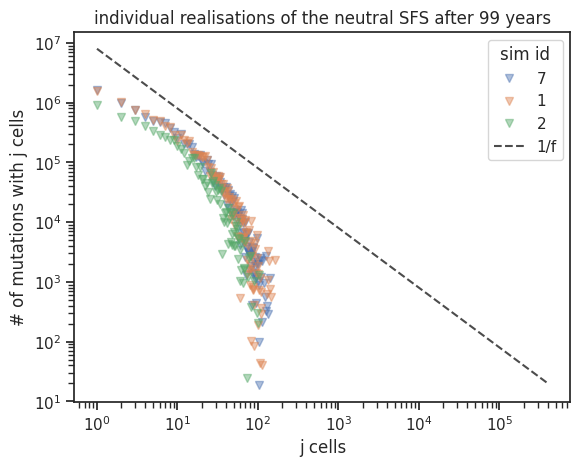

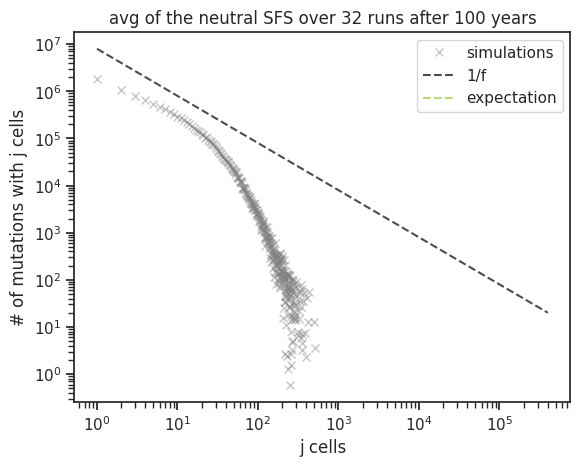

In [21]:
fig, ax = plt.subplots(1, 1)
for k in ("7", "1", "2"):
    plot_sfs(neutral_sfs[k], ax)
ax.set_ylabel("# of mutations with j cells")
ax.set_xlabel("j cells")
x_ = np.arange(1, 2 * NCELLS)
y_ = 2 * NEUTRAL_RATE * NCELLS / x_
ax.plot(x_, y_, linestyle="--", c="black", alpha=0.7, label="1/f")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(f"individual realisations of the neutral SFS after {YEARS - 1} years")
ax.legend(title="sim id")
plt.show()

fig, ax = plt.subplots(1, 1)
ax.plot(
    jcells,
    avg_neutral_sfs,
    alpha=0.45,
    marker="x",
    linestyle="",
    c="grey",
    label="simulations",
)
ax.set_ylabel("# of mutations with j cells")
ax.set_xlabel("j cells")
x_ = np.arange(1, 2 * NCELLS)
y_ = 2 * NEUTRAL_RATE * NCELLS / x_
ax.plot(x_, y_, linestyle="--", c="black", alpha=0.7, label="1/f")
# Watson, C.J. et al. (2020)
# ‘The evolutionary dynamics and fitness landscape of clonal hematopoiesis’,
# Science, 367(6485), pp. 1449–1454 TODO
ax.plot(1, 2, linestyle="--", c="yellowgreen", alpha=0.7, label="expectation")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.set_title(f"avg of the neutral SFS over {RUNS} runs after {YEARS} years")
plt.show()

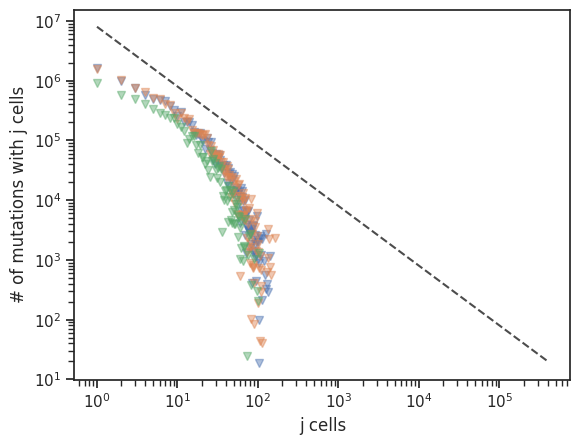

In [22]:
sfs = load_sfs(PATH2SAVE, neutral=False, timepoint=2)

fig, ax = plt.subplots(1, 1)
for k in ("7", "1", "2"):
    plot_sfs(neutral_sfs[k], ax)
x_ = np.arange(1, 2 * NCELLS)
y_ = 2 * NEUTRAL_RATE * NCELLS / x_
ax.plot(x_, y_, linestyle="--", c="black", alpha=0.7)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("# of mutations with j cells")
ax.set_xlabel("j cells")
plt.show()

## Entropy
Compute the entropy of the neutral sfs (all neutral lineages) for all patients.

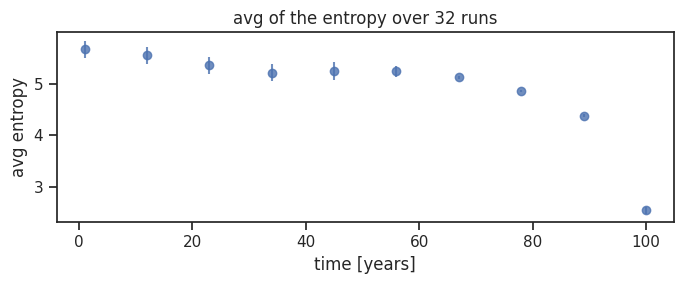

In [11]:
# load all sfs over time
entropies_avg, entropies_std = [], []
entropies = []
for t in range(1, NB_TIMEPOINTS + 1):
    sfs_t = load_sfs(PATH2SAVE, neutral=False, timepoint=t)

    entropy = list()
    # compute the entropy for the run
    for patient, sfs_patient in sfs_t.items():
        jcells = np.fromiter(sfs_patient.keys(), dtype=float)
        jcells /= jcells.sum()
        entropy.append(stats.entropy(jcells))
    for i, e in enumerate(entropy):
        entropies.append((x[t - 1], e, i))
    # average and std of all runs for this timepoint
    entropies_avg.append(np.mean(entropy, axis=-1))
    entropies_std.append(np.std(entropy, axis=-1))

fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=FIGSIZE)
ax.errorbar(
    x,
    entropies_avg,
    yerr=entropies_std,
    fmt="o",
    alpha=0.8,
    label=f"ABM, avg of {RUNS} runs",
)
ax.set_xlabel("time [years]")
ax.set_ylabel("avg entropy")
ax.set_title(f"avg of the entropy over {RUNS} runs")
plt.show()

/home/francesco/venvs/hsc-draft/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


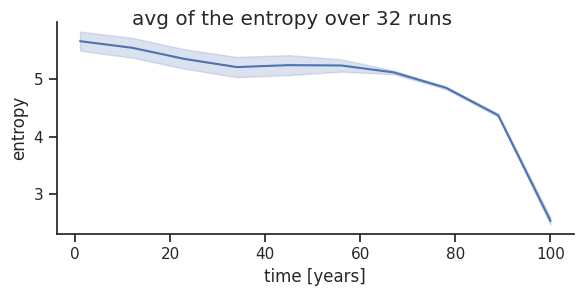

In [12]:
# same plot as above but using sns api
entropies_df = pd.DataFrame(entropies, columns=["time [years]", "entropy", "run"])
rp = sns.relplot(
    data=entropies_df[["time [years]", "entropy"]],
    x="time [years]",
    y="entropy",
    kind="line",
    errorbar="sd",
    aspect=2,
    height=3,
)
rp.fig.suptitle(f"avg of the entropy over {RUNS} runs")
rp.fig.show()

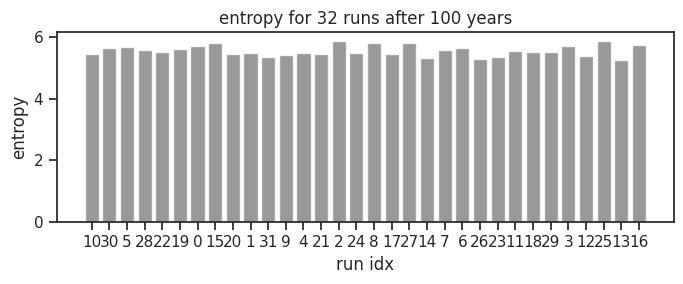

In [14]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=FIGSIZE)

prob_jcells, idx = list(), list()
for patient, sfs_patient in sfs.items():
    jcells = np.fromiter(sfs_patient.keys(), dtype=float)
    jcells /= jcells.sum()
    prob_jcells.append(jcells)
    idx.append(patient)

for xx, pk in zip(idx, prob_jcells):
    ax.bar(xx, stats.entropy(pk), color="grey", alpha=0.8)
ax.set_ylabel("entropy")
ax.set_xlabel("run idx")
ax.set_xticks(range(0, RUNS))
ax.set_title(f"entropy for {RUNS} runs after {YEARS} years")
plt.show()

## Total variant
The total variant fraction is the fraction of all selected clones averaged over all patients, that is anything except the wild type.

In [15]:
def load_variant_fractions(path2dir: Path):
    assert path2dir.is_dir(), "must be dir"
    path2variants = path2dir / "variant_fraction"
    assert (
        len([x for x in path2variants.iterdir() if x.is_dir()]) == NB_TIMEPOINTS
    ), "Wrong number of timepoints saved"

    data = []
    for path2snapshot in sorted(
        list(path2variants.iterdir()),
        key=lambda path2name: int(path2name.name),
        reverse=True,
    ):  # need to reverse because rust saves from the last timepoint
        for file in path2snapshot.iterdir():
            with open(file, "r") as f:
                # remove wild type clone
                data.extend(
                    [
                        float(ele)
                        for i, ele in enumerate(f.read().split(","))
                        if ele and i > 0
                    ]
                )
    return np.array(data, dtype=float).reshape(
        NB_TIMEPOINTS, RUNS, 40 - 1
    )  # timepoints x RUNS x MAX_SUBCLONES - 1 (rm wildtype)

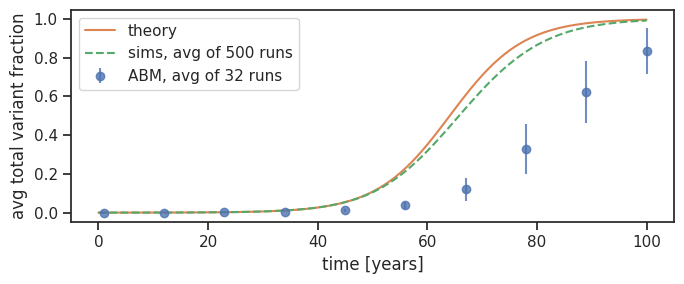

In [16]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=FIGSIZE)
other_sims = pd.read_csv(PATH2SIMS).loc[:YEARS, :]

ax.set_xlabel("time [years]")
ax.set_ylabel("avg total variant fraction")
variant_fraction = load_variant_fractions(PATH2SAVE)
total_fraction = variant_fraction.sum(axis=-1)
ax.errorbar(
    x,
    total_fraction.mean(axis=-1),
    yerr=total_fraction.std(axis=-1),
    fmt="o",
    alpha=0.8,
    label=f"ABM, avg of {RUNS} runs",
)
ax.plot(other_sims._t, other_sims.theory, label="theory")
ax.plot(
    other_sims._t, other_sims.simsAverage, linestyle="--", label="sims, avg of 500 runs"
)
ax.legend(loc="upper left")
if SAVE:
    path2figure = PATH2SAVE / "figures"
    try:
        plt.savefig(path2figure / f"total_variant{EXTENSION}")
    except FileNotFoundError:
        path2figure.mkdir()
        plt.savefig(path2figure / f"total_variant{EXTENSION}")
plt.show()

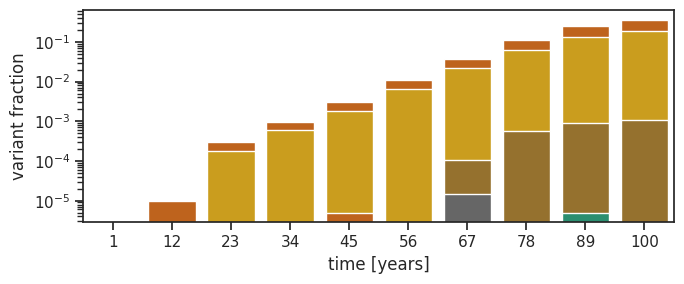

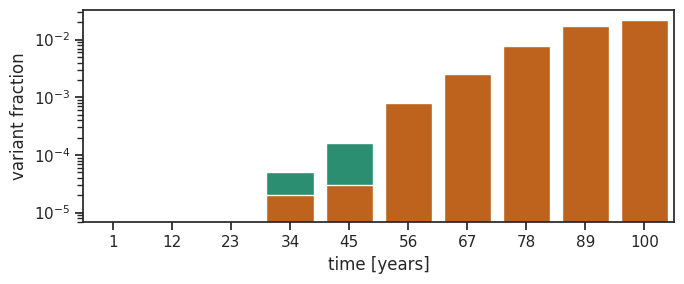

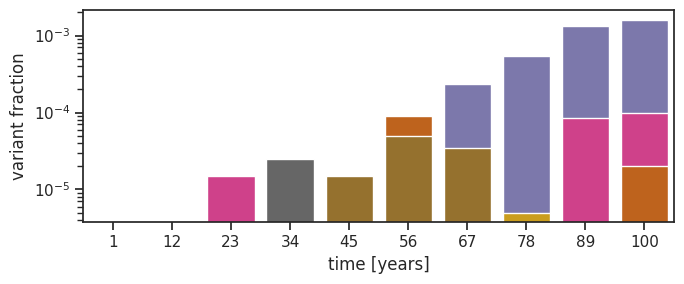

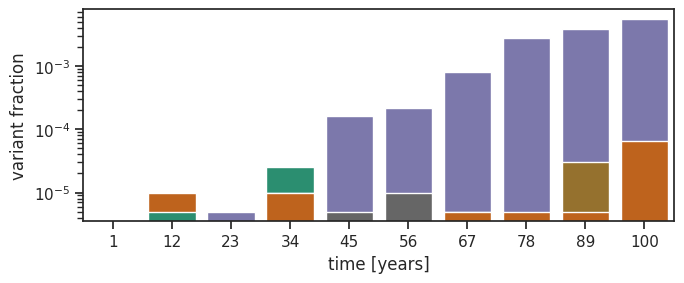

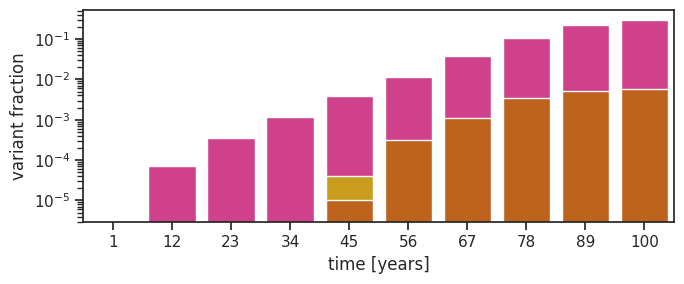

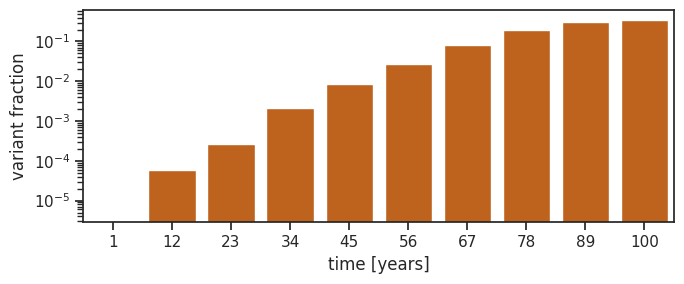

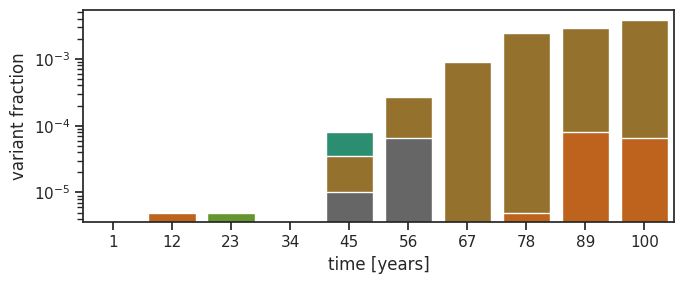

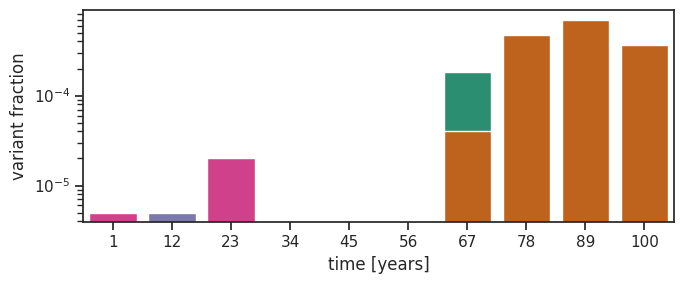

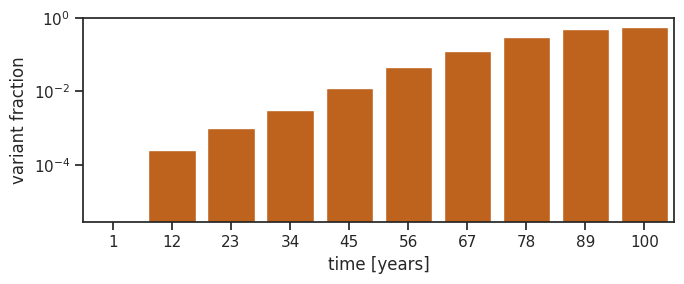

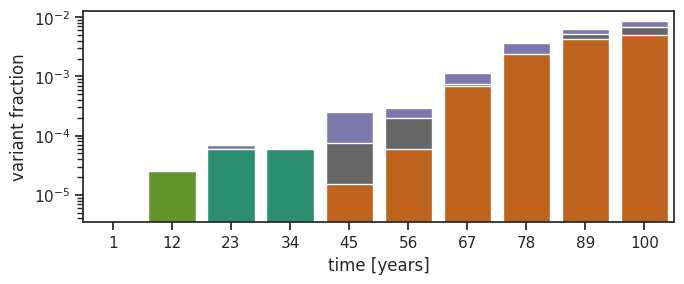

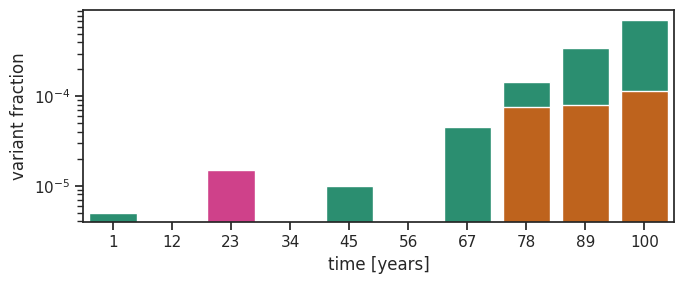

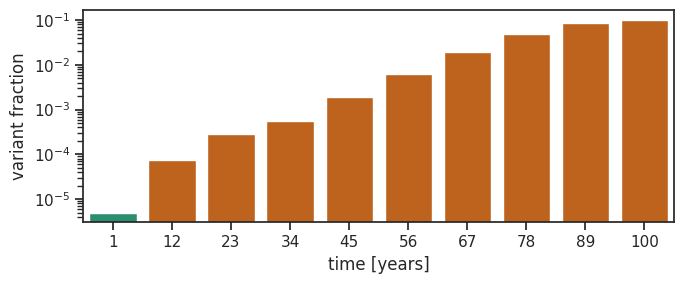

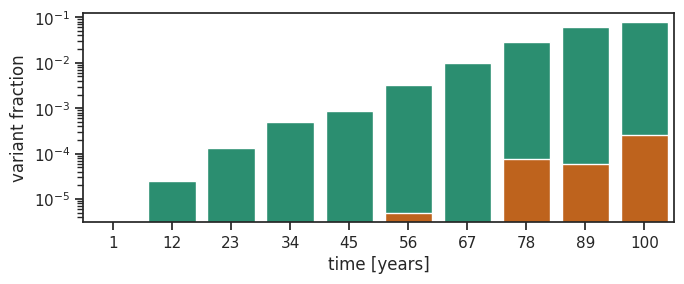

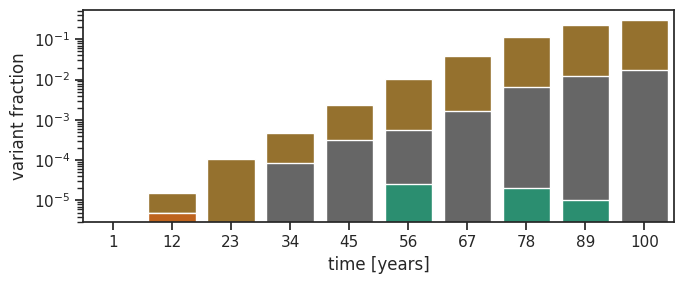

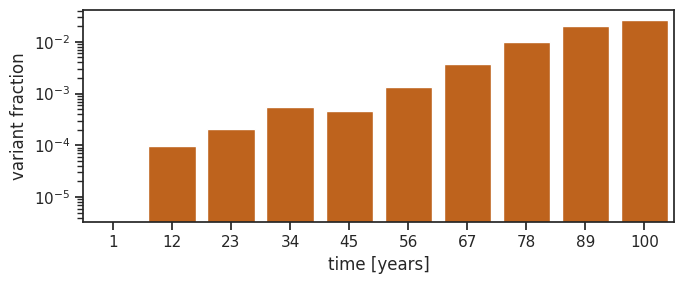

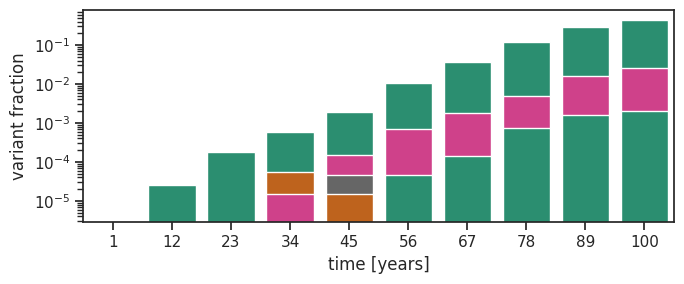

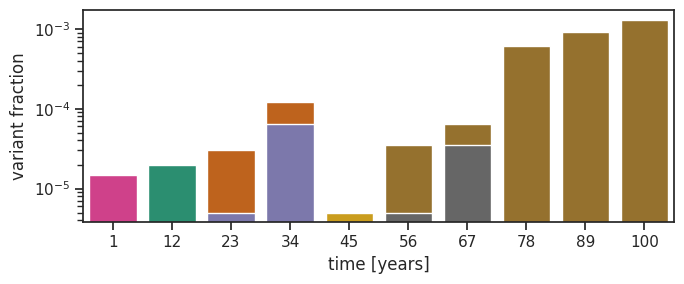

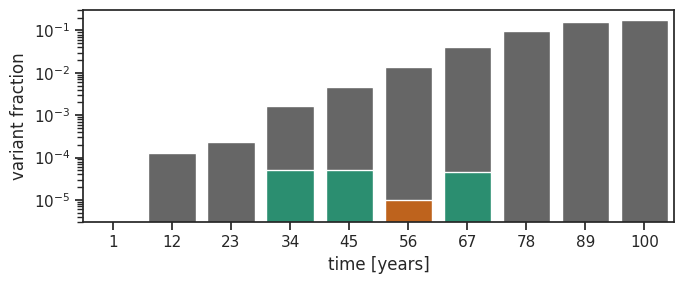

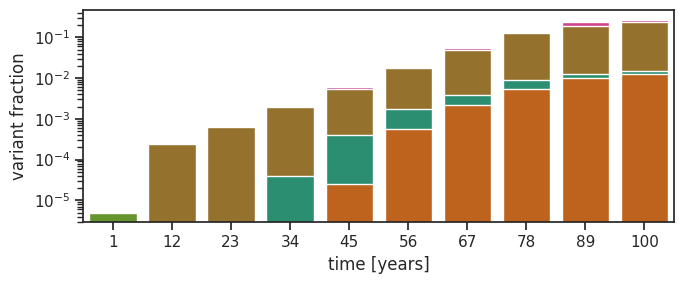

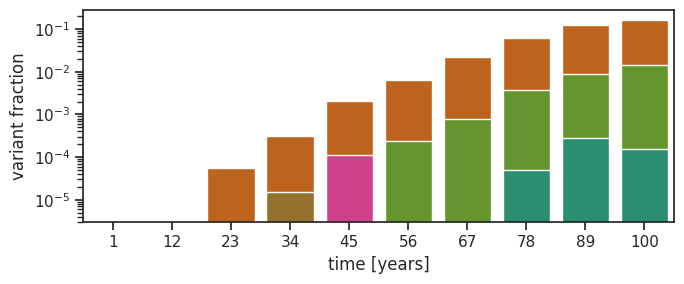

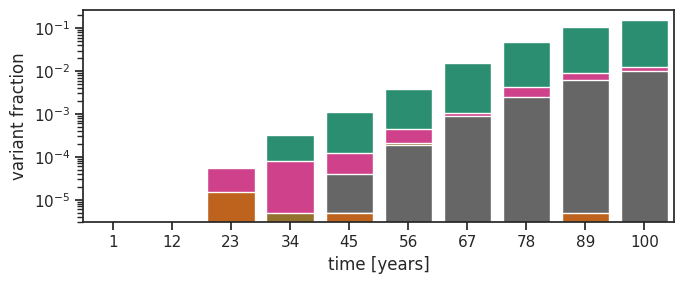

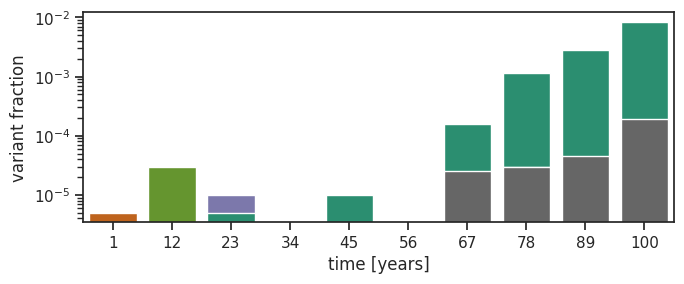

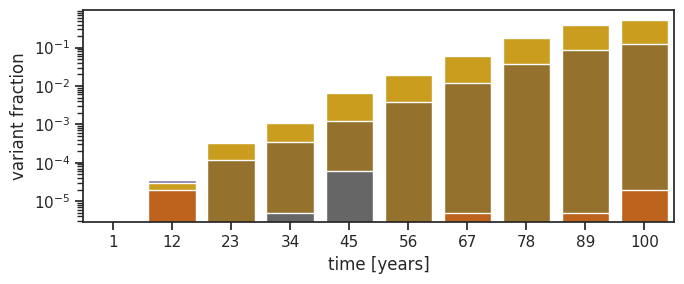

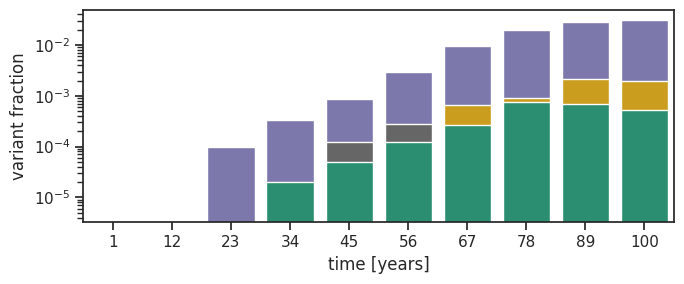

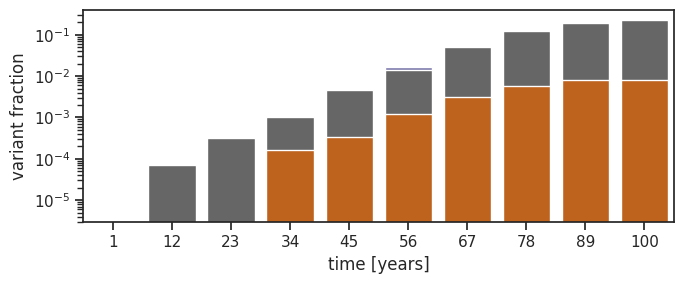

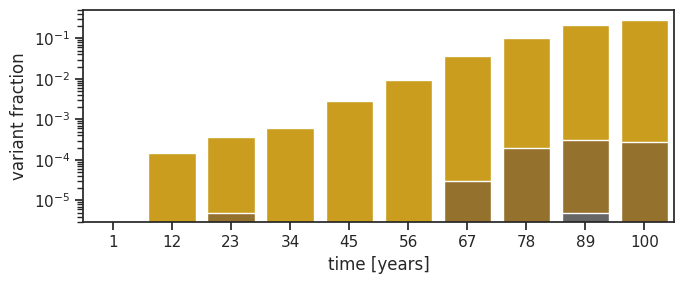

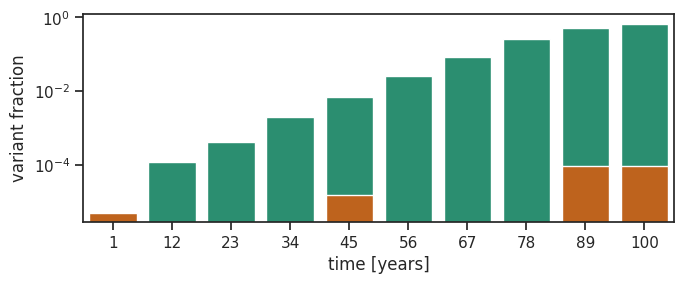

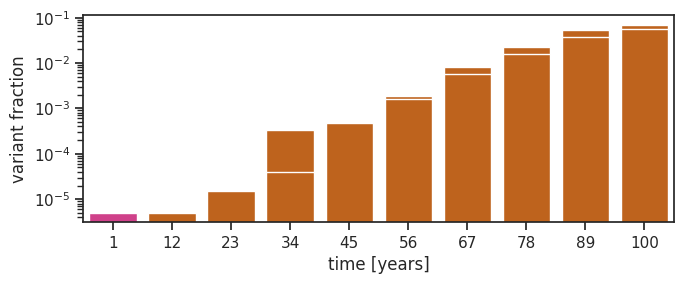

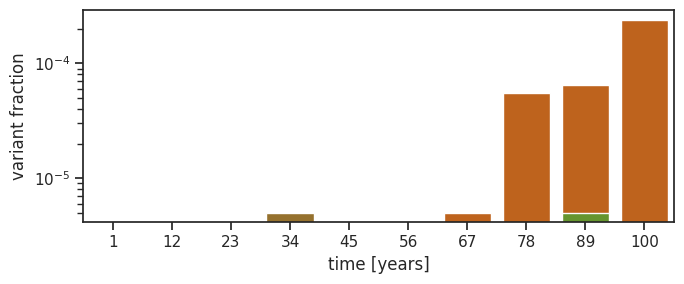

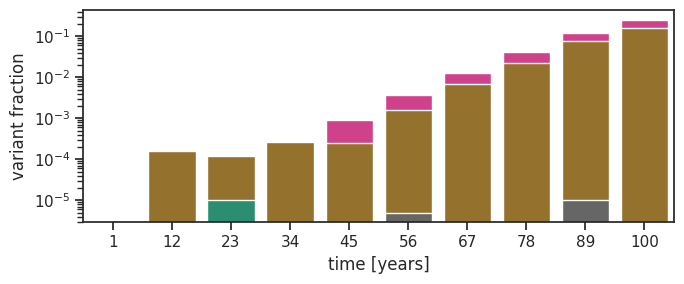

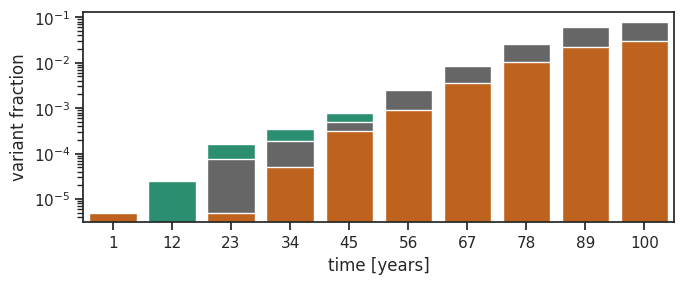

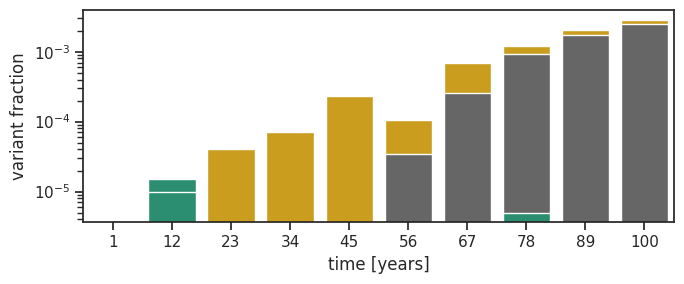

In [17]:
int_x = [round(x_) for x_ in x]
for run in range(RUNS):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=FIGSIZE)
    for clone, c in zip(
        range(variant_fraction.shape[-1]), sns.color_palette("Dark2", n_colors=10)
    ):
        sns.barplot(x=int_x, y=variant_fraction[:, run, clone], ax=ax, color=c)
    ax.set_ylabel("variant fraction")
    ax.set_xlabel("time [years]")
    ax.set_yscale("log")
    plt.show()